In [1]:
! pip install chainer==1.24.0

In [2]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import numpy as np
from chainer import optimizers

In [3]:
class ArtificialData(object):
    """
    人口データを作成するクラス
    """

    def __init__(self, n_samples=100, noise_scale=.1):
        self.n_samples = n_samples
        self.noise_scale = noise_scale

    def true_function(self, x):
        """
        ノイズのない正しいデータを返す関数
        :param x:
        :return:
        :rtype: np.ndarray
        """
        raise NotImplementedError

    def make_x(self):
        return np.sort(np.random.uniform(-1.5, 1.5, size=self.n_samples)).astype(np.float32).reshape(-1, 1)

    def make_noise(self, x):
        return np.random.normal(loc=0, scale=self.noise_scale, size=x.shape)

    def generate(self):
        x = self.make_x()
        y = self.true_function(x)
        y += self.make_noise(y)
        return x, y

In [4]:
def func2(x):
    """
    人口データの正しい関数その2
    :param np.ndarray x:
    :return:
    :rtype: np.ndarray
    """
    return np.sin(5 * x) * np.abs(x)

In [5]:
class Art2(ArtificialData):
    def true_function(self, x):
        return func2(x)

    def make_x(self):
        x1 = np.random.uniform(-1.5, -.5, size=int(self.n_samples / 2))
        x2 = np.random.uniform(.5, 1.5, size=self.n_samples - x1.shape[0])
        x = np.vstack((x1, x2)).reshape(-1, 1)
        return np.sort(x)

In [6]:
def make_data(size, seed=1):
    """
    人工データの作成
    
    :param int size: 
    :param str function_type:
    :param int seed: 
    :return: データと正しい関数の集合
    :rtype: tuple[np.array, np.array, function]
    """
    np.random.seed(seed)
    x, y = Art2(size).generate()
    return x, y

In [7]:
x_test = None
x_train, y_train = make_data(size=100)

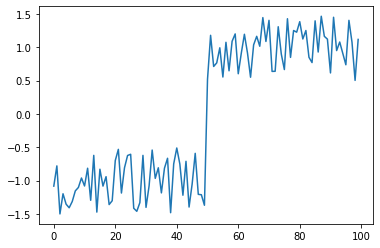

In [8]:
import matplotlib.pyplot as plt
plt.plot(x_train)

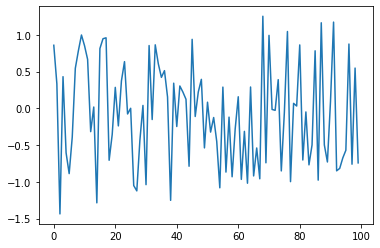

In [9]:
plt.plot(y_train)

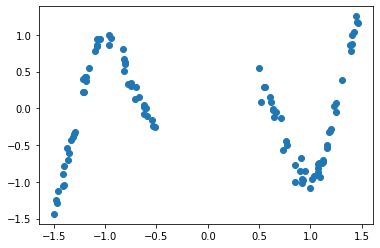

In [10]:
plt.scatter(x_train, y_train)

In [11]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

In [12]:
model_params = {
    "input_dim": input_dim,
    "output_dim": output_dim,
    "mask_type": 'dropout',
    "activate": 'relu',
    "hidden_dim": 512
}

train_params = {
    "n_epoch": 1000,
    "X": x_train,
    "y": y_train,
    "x_test": x_test,
    "data_name": 'art2'
}

In [13]:
class PreprocessMixin(object):
    """
    特徴量の前処理を行うMixinクラス
    """

    def preprocess(self, X, y=None):
        """
        入力変数の変換
        :param np.ndarray X:
        :param np.ndarray y:
        :return: 変換後の変数のタプル
        :rtype: tuple of (numpy.ndarray, numpy.ndarray)
        """
        x_transformed = self.x_transformer.transform(X)
        if y is None:
            return x_transformed

        y_transformed = self.y_transformer.transform(y)
        return x_transformed, y_transformed

    def inverse_y_transform(self, y):
        """
        予測値の逆変換
        :param y: 
        :return: 
        """
        return self.y_transformer.inverse_transform(y)

In [14]:
from chainer import Chain
import chainer.functions as F
import chainer.links as L
class BNN(Chain):
    """
    ベイジアンニューラルネットの重み学習を行うクラス
    """

    def __init__(self, input_dim, output_dim,
                 hidden_dim=512, activate="relu", mask_type="gaussian", prob=.5, lengthscale=10.):
        """
        :param int input_dim: 入力層の次元数
        :param int output_dim: 出力層の次元数
        :param int hidden_dim: 隠れ層の次元数
        :param str activate: 活性化関数
        :param str mask_type: 
            変数へのマスクの種類を表すstring. 
            "dropout", "gaussian", Noneのいずれかを指定
        :param float prob: 
            dropoutの確率を表すfloat. 
            0.のときdropoutをしないときに一致します. 
            [0, 1) の小数
        :param float lengthscale:
            初期のネットワーク重みの精度パラメータ. 大きい値になるほど0に近い値を取ります. 
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.activate_name = activate
        self.activate = self._get_function(activate)
        self.mask_type = mask_type
        self.lengthscale = lengthscale

        super().__init__(
            l1=L.Linear(input_dim, hidden_dim,
                        initial_bias=np.random.normal(scale=1. / lengthscale, size=(hidden_dim)),
                        initialW=np.random.normal(scale=1. / lengthscale, size=(hidden_dim, input_dim))),
            l2=L.Linear(hidden_dim, hidden_dim,
                        initial_bias=np.random.normal(scale=1. / lengthscale, size=(hidden_dim)),
                        initialW=np.random.normal(scale=1. / lengthscale, size=(hidden_dim, hidden_dim))),
            l3=L.Linear(hidden_dim, hidden_dim,
                        initial_bias=np.random.normal(scale=1. / lengthscale, size=(hidden_dim)),
                        initialW=np.random.normal(scale=1. / lengthscale, size=(hidden_dim, hidden_dim))),
            l4=L.Linear(hidden_dim, output_dim,
                        initial_bias=np.random.normal(scale=1. / lengthscale, size=(output_dim)),
                        initialW=np.random.normal(scale=1. / lengthscale, size=(output_dim, output_dim)))
        )

        self.mask = Mask(name=mask_type, prob=prob)

    def _get_function(self, s):
        """
        文字列からそれに対応する関数を取得
        
        :param str s: 関数を表す文字列
        :return: 
        """
        if s == "relu":
            f = F.relu
        elif s == "sigmoid":
            f = F.sigmoid
        elif s == "tanh":
            f = F.tanh
        else:
            print("対応する関数が見つかりません")
            f = lambda x: x
        return f

    def __call__(self, x, apply_input=False, apply_hidden=True):
        """
        ネットワークの出力を作成
        
        :param Variable x: 入力ベクトル
        :param bool apply_hidden: 
            隠れ層に対してマスクをかけるかのフラグ. 
            True のときm `mask` によって生成されたマスクを隠れ層に掛ける
        :param bool apply_input:
            入力層に対してマスクをかけるかのフラグ. 
            True にすると学習が不安定になることが観測されているため, 学習時には False が推奨
        :return: 出力
        :rtype: Variable
        """
        x1 = self.mask.apply(x, apply_input)
        h1 = self.activate(self.l1(x1))

        h1 = self.mask.apply(h1, apply_hidden)
        h2 = self.activate(self.l2(h1))

        h2 = self.mask.apply(h2, apply_hidden)
        h3 = self.activate(self.l3(h2))

        h3 = self.mask.apply(h3, apply_hidden)
        h4 = self.l4(h3)
        return h4

    def __str__(self):
        """
        ネットワークの条件をいい感じの文字列で表現する
        :return: ネットワーク条件の文字
        :rtype: str
        """
        s = "hidden={0.hidden_dim}_activate={0.activate_name}_{0.mask}".format(self)
        return s

In [15]:
class Mask(object):
    """
    入力変数に数値を掛けて摂動を与える関数クラス
    """

    def __init__(self, name="dropout", prob=.5):
        """
        :param str name: マスクに用いる手法の名前. "dropout", "gaussian", None のいずれかを指定
        :param float prob: マスクの確率
        """

        self.prob = self._check_prob(prob)
        self.name = name
        if name == "dropout":
            self.mask_generator = self._dropout_mask
        elif name == "gaussian":
            self.mask_generator = self._gaussian_mask
        elif name is None or name.lower() == "none":
            self.mask_generator = self._none_mask
        else:
            raise NameError("name: {name} に該当するmask関数が見当たりません. ".format(**locals()))

    def __repr__(self):
        s = "maskname={0.name}_prob={0.prob}".format(self)
        return s

    def _check_prob(self, prob):
        if prob >= 1.:
            prob = 1.
        elif prob < 0:
            prob = 0
        return prob

    def _dropout_mask(self, size):
        z = np.random.binomial(1, self.prob, size=size).astype(np.float32) * self.prob ** -1
        return z

    def _gaussian_mask(self, size):
        sigma = self.prob / (1. - self.prob)
        z = np.random.normal(loc=1., scale=sigma, size=size).astype(np.float32)
        return z

    def _none_mask(self, size):
        return np.array([1.] * size).astype(np.float32)

    def _make(self, size):
        z = self.mask_generator(size)
        return Variable(np.diag(z))

    def apply(self, h, do_mask=True):
        """
        ベクトルにマスクを掛ける関数
        :param Variable h: マスクされる変数
        :return: masked variable
        :rtype: Variable
        """
        if do_mask is False:
            return h

        size = h.shape[1]
        z = self._make(size)
        z = F.matmul(h, z)
        return z

In [16]:
class Transformer(object):
    """
    変数変換の実行クラス
    初めて変数が与えられたとき, 変換と同時にスケーリングのパラメータを学習し保存します。
    二回目以降は、一度目で学習したパラメータを用いて変換を行います。
    """

    def __init__(self, transform_log=False, scaling=False):
        """
        コンストラクタ
        :param bool transform_log: 目的変数をログ変換するかのbool. 
        :param bool scaling: 
        """
        self._is_fitted = False
        self.transform_log = transform_log
        self.scaling = scaling
        if scaling:
            self.scaler = StandardScaler()

    def _scaling(self, x):
        """

        :param np.ndarray x: 変換する変数配列
        :return: 
        :rtype: np.ndarray
        """
        shape = x.shape
        if len(shape) == 1:
            x = x.reshape(-1, 1)

        if self._is_fitted:
            x = self.scaler.transform(x)
        else:
            x = self.scaler.fit_transform(x)
            self._is_fitted = True
        x = x.reshape(shape)
        return x

    def transform(self, x):
        """
        目的変数のリストを受け取って変換器を作成し, 変換後の値を返す
        * log変換 -> scaling変換 [-1,+1]

        :param np.ndarray x:
        :rtype: np.ndarray
        """
        x_trains = x[:]
        if self.transform_log:
            x_trains = np.log(x)

        if self.scaling:
            x_trains = self._scaling(x)

        return x_trains

    def inverse_transform(self, x):
        """
        変換された値を元の値に逆変換
        :param x: np.ndarray
        :return: np.ndarray
        """
        x_inv = x[:]
        if self.scaling:
            x_inv = self.scaler.inverse_transform(x)

        if self.transform_log:
            x_inv = np.exp(x_inv)

        return x_inv

In [17]:
class BNNEstimator(BaseEstimator, PreprocessMixin):
    """
    Bayesian Neural Network を訓練し可視化を行うクラス
    """

    def __init__(self, input_dim, output_dim, hidden_dim=512, activate="relu", mask_type="gaussian", prob=.5,
                 lengthscale=10., optimizer="adam", weight_decay=4 * 10 ** -5, apply_input=False,
                 x_scaling=True, y_scaling=True):
        """
        :param int input_dim: 入力層の次元数
        :param int output_dim: 出力層の次元数
        :param int hidden_dim: 隠れ層の次元数
        :param str activate: 活性化関数
        :param str mask_type:
            変数へのマスクの種類を表すstring.
            "dropout", "gaussian", None のいずれかを指定
        :param float prob:
            dropoutの確率を表す [0, 1) の小数.
            0.のときdropoutをしないときに一致します.
        :param float lengthscale:
            初期のネットワーク重みの精度パラメータ. 大きい値になるほど0に近い値を取ります.
        :param str optimizer: optimizer を指す string.
        :param float weight_decay:
            勾配の減衰パラメータ.
            目的関数に対して, 指定した重みの加わったL2ノルム正則化と同じ役割を果たします.
        :param bool apply_input:
            入力次元に対して mask を適用するかどうかを表す bool.
        :param bool x_scaling:
            入力変数を正規化するかを表す bool.
        :param bool y_scaling:
            目的変数を正規化するかを表す bool.
        """

        self.model = BNN(input_dim, output_dim, hidden_dim, activate, mask_type, prob,
                         lengthscale)
        self.weight_decay = weight_decay
        self.apply_input = apply_input
        self.x_transformer = Transformer(scaling=x_scaling)
        self.y_transformer = Transformer(scaling=y_scaling)

        if optimizer == "adam":
            self.optimizer = optimizers.Adam()
        self.conditions = str(self.model)

    def fit(self, X, y, x_test=None, data_name=None, n_epoch=1000, batch_size=20, freq_print_loss=10, freq_plot=50,
            n_samples=100):
        """
        モデルのパラメータチューニングの開始
        :param np.ndarray X:
        :param np.ndarray y:
        :param np.ndarray | None x_test:
        :param str | None data_name:
        :param int n_epoch:
        :param int batch_size:
        :param int freq_print_loss:
        :param int freq_plot:
        :param int n_samples: 事後分布プロットの際の事後分布のサンプリング数.
        :return: self
        """
        conditions = self.conditions
        output_dir = "data/{data_name}/{conditions}".format(**locals())
        # 画像の出力先作成
        if os.path.exists(output_dir) is False:
            os.makedirs(output_dir)

        X, y = self.preprocess(X, y)
        if x_test is not None:
            x_test = self.x_transformer.transform(x_test)

        N = X.shape[0]

        # Variable 型への変換
        X = Variable(preprocess_array_format(X))
        y = Variable(preprocess_array_format(y))
        if x_test is not None:
            x_test = Variable(preprocess_array_format(x_test))

        self.optimizer.setup(self.model)
        self.optimizer.add_hook(WeightDecay(self.weight_decay))
        list_loss = []

        for e in range(1, n_epoch + 1):
            perm = np.random.permutation(N)
            for i in range(0, N, batch_size):
                idx = perm[i: i + batch_size]
                _x = X[idx]
                _y = y[idx]
                self.model.zerograds()
                loss = F.mean_squared_error(self.model(_x, apply_input=self.apply_input), _y)
                loss.backward()
                self.optimizer.update()

            l = F.mean_squared_error(self.model(X, False, False), y).data
            if e % freq_print_loss == 0:
                print("epoch: {e}\tloss:{l}".format(**locals()))

            if e % freq_plot == 0:
                fig, ax = self.plot_posterior(x_test, X.data, y.data, n_samples=n_samples)
                ax.set_title("epoch:{0:04d}".format(e))
                fig.tight_layout()
                file_path = os.path.join(output_dir, "epoch={e:04d}.png".format(**locals()))
                fig.savefig(file_path, dpi=150)
                plt.close("all")
            list_loss.append([e, l])

        save_logloss(list_loss, self.model.__str__())

    def plot_posterior(self, x_test, x_train=None, y_train=None, n_samples=100):
        model = self.model
        if x_test is None:
            xx = np.linspace(-2.5, 2.5, 200).reshape(-1, 1)
        else:
            xx = self.x_transformer.inverse_transform(x_test)

        x_train, y_train = self.x_transformer.inverse_transform(x_train), self.inverse_y_transform(y_train)
        predict_values = self.posterior(xx, n=n_samples)

        predict_mean = predict_values.mean(axis=0)
        predict_var = predict_values.var(axis=0)
        tau = (1. - model.mask.prob) * self.model.lengthscale ** 2. / (2 * len(x_train) * self.weight_decay)
        predict_var += tau ** -1

        fig = plt.figure(figsize=(6, 6))
        ax1 = fig.add_subplot(111)
        ax1.plot(x_train[:, 0], y_train[:, 0], "o", markersize=6., color="C0", label="Training Data Points",
                 fillstyle="none")

        for i in range(100):
            if i == 0:
                ax1.plot(xx[:, 0], predict_values[i], color="C1", alpha=.1, label="Posterior Samples", linewidth=.5)
            else:
                ax1.plot(xx[:, 0], predict_values[i], color="C1", alpha=.1, linewidth=.5)

        ax1.plot(xx[:, 0], predict_mean, "--", color="C1", label="Posterior Mean")
        ax1.fill_between(xx[:, 0], predict_mean + predict_var, predict_mean - predict_var, color="C1",
                         label="1 $\sigma$", alpha=.5)

        ax1.set_ylim(-3.2, 3.2)
        ax1.set_xlim(min(xx), max(xx))
        ax1.legend(loc=4)
        return fig, ax1

    def posterior(self, x, n=3):
        """
        :param np.ndarray x:
        :param int n: 
        :return:
        :rtype: np.ndarray
        """
        x = preprocess_array_format(x)
        x = self.preprocess(x)
        x = Variable(x)
        pred = [self.model(x, apply_input=False, apply_hidden=True).data.reshape(-1) for _ in range(n)]
        pred = self.inverse_y_transform(pred)
        pred = np.array(pred)
        return pred
    

In [18]:
def save_logloss(loss, name, save=True):
    """
    loss の epoch による変化を plot して保存.
    :param list loss: loss が格納されたリスト
    :param str name: ファイル名
    :param bool save: 保存するかどうかのフラグ. True のとき name で保存する.
    :return:
    """
    loss = np.array(loss)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(loss[:, 1], color="C0")
    ax1.set_yscale("log")
    if save:
        fig.savefig("{name}.png".format(**locals()), dpi=150)
    return

In [19]:
clf = BNNEstimator(**model_params)

In [20]:
def preprocess_array_format(x):
    """
     array の shape, 及び type をチェックして chainer に投げられるようにする.

    1. shapeの修正:
         (n_samples, ) -> (n_samples, 1)
    2. dtype の修正:
        int -> np.int32
        float -> np.float32

    :param np.ndarray x:
    :return:
    :rtype: np.ndarray
    """
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)

    if np.issubdtype(x.dtype, np.integer):
        x = x.astype(np.int32)
    elif np.issubdtype(x.dtype, np.float):
        x = x.astype(np.float32)
    else:
        x = x.astype(np.float32)
    return x

/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 10	loss:1.004298448562622
epoch: 20	loss:1.0227398872375488
epoch: 30	loss:1.0267128944396973
epoch: 40	loss:1.0263354778289795
epoch: 50	loss:1.0270953178405762


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 60	loss:1.0280005931854248
epoch: 70	loss:1.020185112953186
epoch: 80	loss:1.0107232332229614
epoch: 90	loss:1.001599907875061
epoch: 100	loss:0.9890106320381165


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 110	loss:0.9645605683326721
epoch: 120	loss:0.8967832326889038
epoch: 130	loss:0.8826843500137329
epoch: 140	loss:0.8168964385986328
epoch: 150	loss:0.7590569257736206


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 160	loss:0.7098525762557983
epoch: 170	loss:0.6795360445976257
epoch: 180	loss:0.7696861028671265
epoch: 190	loss:0.6096469759941101
epoch: 200	loss:0.5603169798851013


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 210	loss:0.5639575719833374
epoch: 220	loss:0.661750853061676
epoch: 230	loss:0.5040815472602844
epoch: 240	loss:0.4831114113330841
epoch: 250	loss:0.5152754187583923


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 260	loss:0.5356369614601135
epoch: 270	loss:0.4400288462638855
epoch: 280	loss:0.4957486391067505
epoch: 290	loss:0.37987691164016724
epoch: 300	loss:0.4343932867050171


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 310	loss:0.3260047137737274
epoch: 320	loss:0.29293566942214966
epoch: 330	loss:0.3078378140926361
epoch: 340	loss:0.3997209072113037
epoch: 350	loss:0.2680710554122925


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 360	loss:0.24328464269638062
epoch: 370	loss:0.24660418927669525
epoch: 380	loss:0.2088099718093872
epoch: 390	loss:0.1925014853477478
epoch: 400	loss:0.27656975388526917


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 410	loss:0.33547860383987427
epoch: 420	loss:0.19830834865570068
epoch: 430	loss:0.1904892921447754
epoch: 440	loss:0.3111709654331207
epoch: 450	loss:0.2698090672492981


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 460	loss:0.16978098452091217
epoch: 470	loss:0.1561139076948166
epoch: 480	loss:0.17401456832885742
epoch: 490	loss:0.17667363584041595
epoch: 500	loss:0.14382673799991608


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 510	loss:0.10066761821508408
epoch: 520	loss:0.14502611756324768
epoch: 530	loss:0.1180836483836174
epoch: 540	loss:0.13061414659023285
epoch: 550	loss:0.09348414093255997


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 560	loss:0.11551638692617416
epoch: 570	loss:0.08263665437698364
epoch: 580	loss:0.11241800338029861
epoch: 590	loss:0.16554927825927734
epoch: 600	loss:0.2765944004058838


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 610	loss:0.09080250561237335
epoch: 620	loss:0.09118907153606415
epoch: 630	loss:0.16516244411468506
epoch: 640	loss:0.1456010937690735
epoch: 650	loss:0.0789436399936676


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 660	loss:0.1479330062866211
epoch: 670	loss:0.07274215668439865
epoch: 680	loss:0.14031636714935303
epoch: 690	loss:0.10647208988666534
epoch: 700	loss:0.16157355904579163


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 710	loss:0.06553380191326141
epoch: 720	loss:0.08494752645492554
epoch: 730	loss:0.10825368762016296
epoch: 740	loss:0.15554288029670715
epoch: 750	loss:0.11689270287752151


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 760	loss:0.11236072331666946
epoch: 770	loss:0.08017472922801971
epoch: 780	loss:0.14219948649406433
epoch: 790	loss:0.08709849417209625
epoch: 800	loss:0.10361543297767639


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 810	loss:0.08945874869823456
epoch: 820	loss:0.06020297855138779
epoch: 830	loss:0.09640295803546906
epoch: 840	loss:0.10466558486223221
epoch: 850	loss:0.07416050136089325


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 860	loss:0.09064097702503204
epoch: 870	loss:0.08762867748737335
epoch: 880	loss:0.06421578675508499
epoch: 890	loss:0.15018507838249207
epoch: 900	loss:0.07093709707260132


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 910	loss:0.05216648429632187
epoch: 920	loss:0.1021089106798172
epoch: 930	loss:0.10438498854637146
epoch: 940	loss:0.08821415901184082
epoch: 950	loss:0.07354738563299179


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


epoch: 960	loss:0.09814909845590591
epoch: 970	loss:0.09614293277263641
epoch: 980	loss:0.060491036623716354
epoch: 990	loss:0.11993472278118134
epoch: 1000	loss:0.04841609299182892


/tmp/ipykernel_4329/2420476139.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif np.issubdtype(x.dtype, np.float):


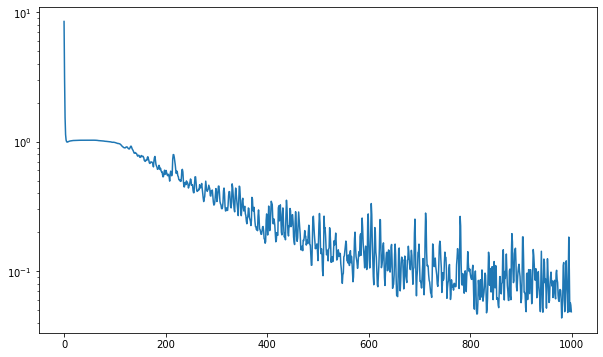

In [21]:
import os
from chainer import Variable
from chainer.optimizer import WeightDecay
clf.fit(**train_params)

In [22]:
from glob import glob
import os
from PIL import Image

def make_anime(files, name='anime'):
    images = list(map(lambda file : Image.open(file) , files))
    images[0].save(name+'.gif', save_all=True, \
        append_images=images[1:], optimize=True, duration=10 , loop=0)

l1_images = glob(os.path.join('./data/art2/hidden=512_activate=relu_maskname=dropout_prob=0.5',  "*.png"))
make_anime(l1_images, 'anime')

<img src='./anime.gif' width=400></img>